In [80]:
import pandas as pd
import numpy as np
import cv2
import itertools


from cycling_manager.preprocess import split, get_data, preprocess

from cycling_manager.sequences import get_sequences, get_sequence, get_scaler

from cycling_manager.main import get_seq

from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Input, Conv2D, Flatten, MaxPooling2D, Masking, LayerNormalization, RepeatVector, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import Precision


from tensorflow.keras import Model



import tensorflow as tf

In [81]:
df = preprocess(get_data())

full df shape (603619, 25)
full df shape (603619, 25)
Score vertical meters - model: DecisionTreeRegressor() score: 0.9995665259425446
Score vertical meters - model: DecisionTreeRegressor() score: 0.9998831495211359
Score vertical meters - model: KNeighborsClassifier() score: 0.9935449110482526


In [82]:
train, test = split(df, start=2021, end=2022)

In [83]:
train

,name,year,race_name
0,tadej-pogacar,2021,tour-de-france
369,sepp-kuss,2021,vuelta-a-espana
363,mikel-landa,2021,giro-d-italia
364,krists-neilands,2021,giro-d-italia
365,rafal-majka,2021,vuelta-a-espana
...,...,...,...
177,caleb-ewan,2021,tour-de-france
176,bryan-coquard,2021,tour-de-france
175,loic-vliegen,2021,tour-de-france
174,nickolas-dlamini,2021,tour-de-france


In [84]:
train.year.unique(), test.year.unique()

(array([2021]), array([2022]))

In [135]:
y_dec_ls = []
tour_ls = []
season_ls = []
result_ls = []

for name, year, tour in train.values:
    try:
        y_decoder, tour_data, result, season_data = get_sequence(df, name, year, tour, img=True, binary=True, maxlen=30)
        y_dec_ls.append(y_decoder)
        tour_ls.append(tour_data)
        result_ls.append(result)
        season_ls.append(season_data)
    except TypeError:
        pass


 dropped nan for ('manuel-belletti', 2021, 'giro-d-italia')

 dropped nan for ('jacopo-mosca', 2021, 'giro-d-italia')

 dropped nan for ('francesco-gavazzi', 2021, 'giro-d-italia')


In [136]:
season_ls_img = []
to_drop_ls = []

for season in season_ls:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            to_drop_ls.append('race/'+race.split('/')[-1].split('.')[0].replace('_', '/'))
        
    season_ls_img.append(np.array(img_ls))
    
season_ls_img = np.array(season_ls_img)
to_drop_ls = list(dict.fromkeys(to_drop_ls))
    

[ WARN:0@24712.982] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-slovenia-itt_2021_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@24712.982] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-slovenia_2021_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@24713.097] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-france_2021_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@24713.104] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-spain_2021_result.jpg'): can't

In [193]:
season_ls_img.shape

(519,)

In [137]:
tour_ls_img = []

for season in tour_ls:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            print(race)
        
    tour_ls_img.append(np.array(img_ls))
    
tour_ls_img = np.array(tour_ls_img)

/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_8069/764442808.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tour_ls_img = np.array(tour_ls_img)


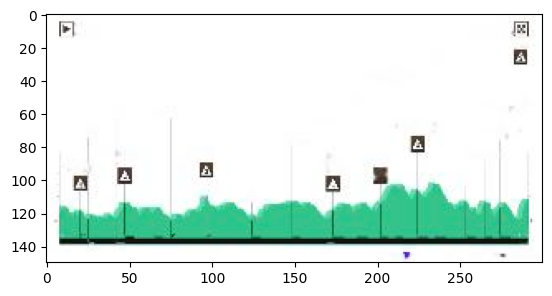

In [138]:

import matplotlib.pyplot as plt

arr = tour_ls_img[0][0]

arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

In [139]:
result_ls_2 = [list(itertools.chain(*x[~x.race_ref.isin(to_drop_ls)].drop(columns='race_ref').values)) for x in result_ls]


In [140]:
y_dec_ls_2 = [list(itertools.chain(*x.values)) for x in y_dec_ls]

In [141]:
to_drop_ls

['race/nc-slovenia-itt/2021/result',
 'race/nc-slovenia/2021/result',
 'race/nc-france/2021/result',
 'race/nc-spain/2021/result',
 'race/danish-championships/2021/result',
 'race/nc-belgium/2020/result',
 'race/nc-germany/2021/result',
 'race/czech-cycling-tour/2021/stage-1',
 'race/czech-cycling-tour/2021/stage-2',
 'race/czech-cycling-tour/2021/stage-3',
 'race/czech-cycling-tour/2021/stage-4',
 'race/nc-portugal/2021/result',
 'race/nc-portugal2/2021/result',
 'race/nc-belgium/2021/result',
 'race/nc-netherlands-itt/2021/result',
 'race/nc-netherlands/2021/result',
 'race/nc-israel/2021/result',
 'race/nc-estonia-itt/2021/result',
 'race/nc-italy/2021/result',
 'race/nc-austria/2021/result',
 'race/nc-switzerland-itt/2021/result',
 'race/nc-spain-itt/2021/result',
 'race/nc-australia/2021/result',
 'race/nc-norway/2020/result',
 'race/czech-cycling-tour/2020/stage-2',
 'race/czech-cycling-tour/2020/stage-3',
 'race/nc-italy-itt/2020/result',
 'race/nc-new-zealand-itt/2021/result',


In [142]:
df_2 = df[~df.race_ref.isin(to_drop_ls)]

In [143]:
def get_sequences_img(season_ls, result_ls):
    new_season_ls = []
    new_result_ls = []
    i=0
    
    for season, results in zip(season_ls, result_ls):
        if season.shape[0] == 0:
            print(f'----- {season.shape[0]}')
            print(i)
            i += 1
            pass
        else:
            #print(season.shape)
            tensors_season = tf.convert_to_tensor(season, dtype=tf.int16)
            new_season_ls.append(tensors_season)
            
            tensors_y = tf.convert_to_tensor(results, dtype=tf.float16)
            new_result_ls.append(tensors_y)
            i += 1
        
    X_encoder_train = tf.ragged.stack(new_season_ls).to_tensor()
    y_encoder_train = tf.ragged.stack(new_result_ls).to_tensor()
    
    return X_encoder_train, y_encoder_train

In [144]:
#X_encoder_img_val, y_encoder_img_val = get_sequences_img(season_ls_img, result_ls_2)
X_encoder_img_train, y_encoder_img_train = get_sequences_img(season_ls_img, result_ls_2)

X_encoder_img_train.shape, y_encoder_img_train.shape

----- 0
115


(TensorShape([518, 30, 150, 300, 3]), TensorShape([518, 30]))

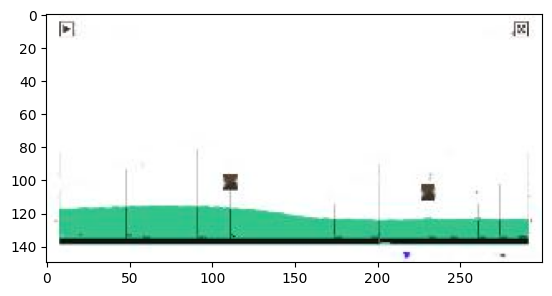

In [145]:
import matplotlib.pyplot as plt

arr = X_encoder_img_train[0][1]
#arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr)
plt.show()

In [146]:
season_ls[115]

array([], dtype=object)

In [147]:
tour_ls_img= np.delete(tour_ls_img, 115)
y_dec_ls_2 = np.delete(y_dec_ls_2, 115)

# tour_ls_img= np.delete(tour_ls_img, 262-1)
# y_dec_ls_2 = np.delete(y_dec_ls_2, 262-1)

# tour_ls_img= np.delete(tour_ls_img, 334-2)
# y_dec_ls_2 = np.delete(y_dec_ls_2, 334-2)

# tour_ls_img= np.delete(tour_ls_img, 455-3)
# y_dec_ls_2 = np.delete(y_dec_ls_2, 455-3)

# tour_ls_img= np.delete(tour_ls_img, 480-4)
# y_dec_ls_2 = np.delete(y_dec_ls_2, 480-4)

#tour_ls_img = np.delete(tour_ls_img, 564-1)
#y_dec_ls_2 = np.delete(y_dec_ls_2, 564-1)


/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/cycling/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [180]:
#X_decoder_val_train, y_decoder_val_train = get_sequences_img(tour_ls_img, y_dec_ls_2)
X_decoder_img_train, y_decoder_img_train = get_sequences_img(tour_ls_img, y_dec_ls_2)


X_decoder_img_train.shape, y_decoder_img_train.shape

(TensorShape([518, 21, 150, 300, 3]), TensorShape([518, 21]))

In [151]:
X_encoder_train, X_decoder_train, y_decoder_train = get_seq(train, df_2, 30, binary=True)

cannot unpack non-iterable NoneType object -- ('krists-neilands', 2021, 'giro-d-italia')

 dropped nan for ('manuel-belletti', 2021, 'giro-d-italia')
cannot unpack non-iterable NoneType object -- ('francois-bidard', 2021, 'giro-d-italia')
cannot unpack non-iterable NoneType object -- ('tomasz-marczynski', 2021, 'giro-d-italia')
cannot unpack non-iterable NoneType object -- ('thomas-de-gendt', 2021, 'giro-d-italia')

 dropped nan for ('jacopo-mosca', 2021, 'giro-d-italia')
cannot unpack non-iterable NoneType object -- ('antonio-nibali', 2021, 'vuelta-a-espana')
cannot unpack non-iterable NoneType object -- ('alexander-cataford', 2021, 'vuelta-a-espana')
cannot unpack non-iterable NoneType object -- ('emmanuel-morin', 2021, 'vuelta-a-espana')
cannot unpack non-iterable NoneType object -- ('sander-armee', 2021, 'vuelta-a-espana')
cannot unpack non-iterable NoneType object -- ('patrick-gamper', 2021, 'vuelta-a-espana')
cannot unpack non-iterable NoneType object -- ('scott-thwaites', 2021, 

In [152]:
X_encoder_train.shape, X_decoder_train.shape, y_decoder_train.shape

((518, 30, 7), (518, 21, 5), (518, 21, 1))

In [153]:
np.unique(y_decoder_train)

array([-1000.,     0.,     1.])

In [190]:
model = Sequential()
# define CNN model
model.add(TimeDistributed(Rescaling(1./255, input_shape=(150,300,3))))

model.add(TimeDistributed(Conv2D(16, kernel_size=10, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Conv2D(32, kernel_size=6, activation="relu")))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(100, activation='relu')))

model.add(TimeDistributed(Dense(30, activation='relu')))


# define LSTM model
model.add(LSTM(units=15, dropout=0.2, return_sequences=True, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

In [191]:
initial_learning_rate = 0.01

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

adam = Adam(learning_rate=lr_schedule)

    
model.compile(optimizer=adam, loss='mean_absolute_error', metrics='mean_absolute_error')

batch_size=8
patience=3
validation_split=0.3

es = EarlyStopping(monitor="val_loss",
                       patience=patience,
                       restore_best_weights=True,
                       verbose=0)

history = model.fit(X_encoder_img_train, y_encoder_img_train,
                        validation_split=validation_split,
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)

Epoch 1/1000
 1/46 [..............................] - ETA: 7:08 - loss: 77.2332 - mean_absolute_error: 77.2332

KeyboardInterrupt: 

In [154]:
from tensorflow.keras.applications.resnet50 import ResNet50

def load_model(train=False):
    
    # $CHALLENGIFY_BEGIN
    
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_decoder_img_train.shape[2:])
    
    if train == False:
        model.trainable = False
    
    # $CHALLENGIFY_END
    
    return model

In [155]:
resnet = load_model(train=False)

In [156]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 306, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 150, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 150, 64)  256         ['conv1_conv[0][0]']      

In [157]:
def encoder_image(images):
    # x = TimeDistributed(Rescaling(1./255, input_shape=(150,300,3)))(images)
    # x = TimeDistributed(Conv2D(16, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(32, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(16, kernel_size=8, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    
    x = TimeDistributed(resnet)(images)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(200, activation='tanh'))(x)
    x = TimeDistributed(Dense(30, activation='tanh'))(x)
    
    return x
    

In [158]:
def decoder_image(images):
    # x = TimeDistributed(Rescaling(1./255, input_shape=(150,300,3)))(images)
    # x = TimeDistributed(Conv2D(16, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(32, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(16, kernel_size=8, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    
    x = TimeDistributed(resnet)(images)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(200, activation='tanh'))(x)
    x = TimeDistributed(Dense(30, activation='tanh'))(x)
    
    return x

In [72]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    
    """This class implents the attention mechanism layer: We will define a class named Attention as a derived class of the Layer class. We need to define four functions as per the Keras custom layer generation rule. 
    These are build(),call (), compute_output_shape() and get_config()."""
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
        
        
    """Inside build (), we will define our weights and biases, i.e., Wa and B . 
    If the previous LSTM layer’s output shape is (None, 32, 100)
    then our output weight should be (100, 1) and bias should be (100, 1) dimensional."""
    def build(self,input_shape):
        self.w=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention,self).build(input_shape)
        
        
    """Inside call (), we will write the main logic of Attention. We simply must create a Multi-Layer Perceptron (MLP). 
    Therefore, we will take the dot product of weights and inputs followed by the addition of bias terms. 
    After that, we apply a ‘tanh’ followed by a softmax layer. This softmax gives the alignment scores. 
    Its dimension will be the number of hidden states in the LSTM, i.e., 32 in this case. 
    Taking its dot product along with the hidden states will provide the context vector:"""    
    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.w)+self.b), axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])
    "The get_config() method collects the input shape and other information about the model."""
    def get_config(self):
        return super(attention,self).get_config()      

In [159]:
def encoder(encoder_features, encoder_image_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    
    y = Concatenate(axis=-1)([y, encoder_image_features])
    
    #each LSTM unit returning a sequence of 6 outputs, one for each time step in the input data
    y = LSTM(units=12, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    y = LSTM(units=20, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    #y = TimeDistributed(Dense(units=5, activation='tanh'))(y)
    #attention_layer = attention()(y)
    y = LSTM(units=10, dropout=0.2, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y

In [160]:
import keras.backend as K

def custom_binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1000.), tf.float32)),
                                    tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1000.), tf.float32))), axis=-1)
    
def custom_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1000.), tf.float32)) * tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1000.), tf.float32)), 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1000.), tf.float32)), 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [175]:
def decoder(decoder_features, encoder_outputs, decoder_image_features):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs, decoder_image_features])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    x = TimeDistributed(Dense(units=20, activation='relu'))(x)
    x = TimeDistributed(Dense(units=8, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1, activation='sigmoid'))(x)
    return y

def combine_model(X_encoder, X_decoder, img_encoder, img_decoder):
    
    # define input shapes
    encoder_features = Input(shape=X_encoder.shape[1:])
    decoder_features = Input(shape=X_decoder.shape[1:])
    encoder_img_features = Input(shape=img_encoder.shape[1:])
    decoder_img_features = Input(shape=img_decoder.shape[1:])
    
    #get cnn output for encoder/decoder
    encoder_img_output = encoder_image(encoder_img_features)
    decoder_img_output = decoder_image(decoder_img_features)
        
    #set encoder
    encoder_outputs = encoder(encoder_features, encoder_img_output)
    
    #set dedocer
    decoder_outputs = decoder(decoder_features, encoder_outputs, decoder_img_output)
    
    #set model
    model = Model([encoder_features, decoder_features, encoder_img_features, decoder_img_features], decoder_outputs)
    
    #print(Fore.YELLOW + f"\nCombined model..." + Style.RESET_ALL)
    
    return model

def compile_model(model):
    
    initial_learning_rate = 0.001

    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=1e-6)

    adam = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=adam, loss=custom_binary_crossentropy, metrics=Precision())
    
    #print(Fore.YELLOW + f"\Compile model..." + Style.RESET_ALL)

    return model

In [176]:
model = combine_model(X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train)

In [177]:
model = compile_model(model)

In [178]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# class categorical_accuracy_no_mask(Callback):
#     def __init__(self, validation_data):
#         super(Callback, self).__init__()
#         self.X_val, self.y_val = validation_data

#     def on_train_begin(self, logs={}):
#        self.val_acc = []
#        self.val_pre = []
#        self.val_rec = []

#     def on_epoch_end(self, epoch, logs={}):
#        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
#        val_targ = self.model.validation_data[1] 
#        indx = np.where(~val_targ.any(axis=2))[-1000.] #find where all targets are zero. That are the masked once as we masked the target with 0 and the data with 666
#        y_true_nomask = np.delete(val_targ, indx, axis=0)
#        y_pred_nomask = np.delete(val_predict, indx, axis=0)

#        _val_precision = precision_score(y_true_nomask, y_pred_nomask)
#        _val_accuracy = accuracy_score(y_true_nomask, y_pred_nomask)
#        _val_recall = recall_score(y_true_nomask, y_pred_nomask)
#        self.val_acc.append(_val_accuracy)
#        self.val_pre.append(_val_precision)
#        self.val_rec.append(_val_recall)

#        print(f'accuracy {_val_accuracy}')
#        print(f'precision {_val_precision}')
#        print(f'recall {_val_recall}')
#        return

class Metrics(Callback):
    
    def __init__(self, val_data, batch_size = 8):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
    
    def on_train_begin(self, logs={}):
        print(self.validation_data)
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total,1))
        val_true = np.zeros((total))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch+1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch+1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred)
        _val_precision = precision_score(val_true, val_pred)
        _val_recall = recall_score(val_true, val_pred)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        return

def train_model(model: Model,
                x_encoder: np.ndarray,
                x_decoder: np.ndarray,
                x_encoder_img,
                x_decoder_img,
                y: np.ndarray,
                batch_size=128,
                patience=20,
                validation_split=0.3,
                validation_data=None):
    """
    Fit model and return a the tuple (fitted_model, history)
    """


    es = EarlyStopping(monitor="val_loss",
                       patience=patience,
                       restore_best_weights=True,
                       verbose=0)

    history = model.fit([x_encoder, x_decoder, x_encoder_img, x_decoder_img],
                        y,
                        validation_split=validation_split,
                        validation_data=validation_data,
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)


    return model, history

In [165]:
X_encoder_train.shape, X_decoder_train.shape, X_encoder_img_train.shape, X_decoder_img_train.shape, y_decoder_train.shape

((518, 30, 7),
 (518, 21, 5),
 TensorShape([518, 30, 150, 300, 3]),
 TensorShape([518, 21, 150, 300, 3]),
 (518, 21, 1))

In [166]:
from tensorflow.keras.applications import resnet50

X_encoder_img_train = resnet50.preprocess_input(X_encoder_img_train)
X_decoder_img_train = resnet50.preprocess_input(X_decoder_img_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


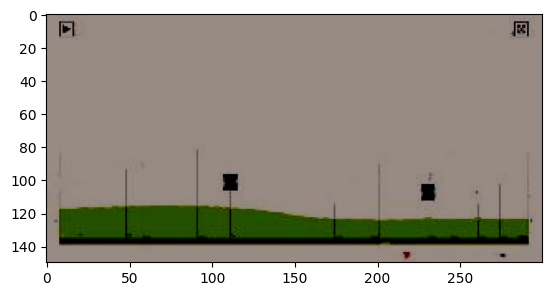

In [167]:
arr = X_encoder_img_train[0][1]
#arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr)
plt.show()

In [168]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 30, 150, 30  0           []                               
                                0, 3)]                                                            
                                                                                                  
 time_distributed_11 (TimeDistr  (None, 30, 5, 10, 2  23587712   ['input_9[0][0]']                
 ibuted)                        048)                                                              
                                                                                                  
 time_distributed_12 (TimeDistr  (None, 30, 102400)  0           ['time_distributed_11[0][0]']    
 ibuted)                                                                                    

In [38]:
np.unique(y_decoder_train, return_counts=True)

(array([-1000.,     0.,     1.]), array([1174, 9080, 1254]))

In [39]:
1254/(9080+1254+1174)

0.10896767466110532

In [179]:
model, history = train_model(model, X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train, y_decoder_train,\
        batch_size=8, patience=3, validation_split=0.2)

Epoch 1/1000
52/52 [==============================] - ETA: 0s - loss: 1.8104 - precision_1: 0.3333

KeyboardInterrupt: 

In [63]:
model.evaluate([X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train], y_decoder_train)

11/11 [==============================] - 551s 50s/step - loss: 37.3954 - mean_absolute_error: 37.3954


[37.395442962646484, 37.39543914794922]

In [64]:
test

,name,year,race_name
0,tadej-pogacar,2022,tour-de-france
1,mikkel-bjerg,2022,tour-de-france
2,rafal-majka,2022,tour-de-france
3,brandon-mcnulty,2022,tour-de-france
4,marc-soler,2022,tour-de-france
...,...,...,...
347,sergio-samitier,2022,giro-d-italia
348,filippo-fiorelli,2022,giro-d-italia
349,jakub-mareczko,2022,giro-d-italia
350,miguel-angel-lopez,2022,giro-d-italia


In [72]:
preds = model.predict([X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train])

11/11 [==============================] - 529s 46s/step


In [109]:
test.shape, preds.shape

((352, 3), (352, 21, 1))

In [121]:
preds[4]

array([[  79.17846 ],
       [  77.8683  ],
       [  78.57882 ],
       [  78.645256],
       [  78.53601 ],
       [  79.34985 ],
       [  78.122635],
       [  78.742676],
       [  77.691956],
       [  78.435135],
       [  78.14743 ],
       [  77.266426],
       [  77.14347 ],
       [  78.16134 ],
       [  78.77844 ],
       [-999.3139  ],
       [-999.3139  ],
       [-999.3139  ],
       [-999.3139  ],
       [-999.3139  ],
       [-999.3139  ]], dtype=float32)

In [122]:
preds[0]

array([[79.17846 ],
       [77.8683  ],
       [78.57882 ],
       [78.645256],
       [78.53601 ],
       [79.34985 ],
       [78.122635],
       [78.742676],
       [77.691956],
       [78.435135],
       [78.14743 ],
       [77.266426],
       [77.14347 ],
       [78.16134 ],
       [78.77844 ],
       [78.22225 ],
       [77.68516 ],
       [77.45139 ],
       [78.25494 ],
       [77.76797 ],
       [78.62801 ]], dtype=float32)

In [116]:
pred_df = pd.concat([pd.DataFrame(x.T) for x in preds])
pred_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,79.178459,77.868301,78.578819,78.645256,78.536011,79.349854,78.122635,78.742676,77.691956,78.435135,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,79.178459,77.868301,78.578819,78.645256,78.536011,79.349854,78.122635,78.742676,77.691956,78.435135,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,79.178459,77.868301,78.578819,78.645256,78.536011,79.349854,78.122635,78.742676,77.691956,78.435135,...,77.266426,77.143471,78.161339,78.778442,78.222252,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,79.178459,77.868301,78.578819,78.645256,78.536011,79.349854,78.122635,78.742676,77.691956,78.435135,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,79.178459,77.868301,78.578819,78.645256,78.536011,79.349854,78.122635,78.742676,77.691956,78.435135,...,77.266426,77.143471,78.161339,78.778442,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,77.688080,77.687416,79.516380,77.770027,79.126122,79.208168,-999.313904,-999.313904,-999.313904,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,77.688080,77.687416,79.516380,77.770027,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,77.688080,77.687416,79.516380,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,77.688080,77.687416,79.516380,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904


In [129]:
pred_df[0].unique()

array([79.17846, 77.68808], dtype=float32)

In [125]:
test

,name,year,race_name
0,tadej-pogacar,2022,tour-de-france
1,mikkel-bjerg,2022,tour-de-france
2,rafal-majka,2022,tour-de-france
3,brandon-mcnulty,2022,tour-de-france
4,marc-soler,2022,tour-de-france
...,...,...,...
347,sergio-samitier,2022,giro-d-italia
348,filippo-fiorelli,2022,giro-d-italia
349,jakub-mareczko,2022,giro-d-italia
350,miguel-angel-lopez,2022,giro-d-italia


In [124]:
pred_df.shape
pred_df 
pred_df

,name_x,year_x,race_name_x,name_y,year_y,race_name_y,0,1,2,3,...,11,12,13,14,15,16,17,18,19,20
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,79.178459,77.868301,78.578819,78.645256,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,79.178459,77.868301,78.578819,78.645256,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,79.178459,77.868301,78.578819,78.645256,...,77.266426,77.143471,78.161339,78.778442,78.222252,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,79.178459,77.868301,78.578819,78.645256,...,77.266426,77.143471,78.161339,78.778442,78.222252,77.685158,77.451393,78.254936,77.767967,78.628014
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,79.178459,77.868301,78.578819,78.645256,...,77.266426,77.143471,78.161339,78.778442,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,77.688080,77.687416,79.516380,77.770027,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,77.688080,77.687416,79.516380,77.770027,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,77.688080,77.687416,79.516380,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904
0,tadej-pogacar,2022,tour-de-france,tadej-pogacar,2022,tour-de-france,77.688080,77.687416,79.516380,-999.313904,...,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904,-999.313904


In [78]:
m,n,r = preds.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),preds.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)
out_df

,0,1
0,0.0,79.178459
1,0.0,77.868301
2,0.0,78.578819
3,0.0,78.645256
4,0.0,78.536011
...,...,...
7387,351.0,-999.313904
7388,351.0,-999.313904
7389,351.0,-999.313904
7390,351.0,-999.313904


In [67]:
model.save('../models/cnn/40/first_full_iter')

KeyboardInterrupt: 

In [ ]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [65]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [66]:
plot_history(history)

NameError: name 'history' is not defined